In [3]:
# ==========================================
# Meteorological Data Preprocessing & Models
# ==========================================

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# -----------------------------
# 1. Load and inspect the data
# -----------------------------
df = pd.read_csv("Disease_with_Weather.csv")

print("Data preview:")
print(df.head())

# -----------------------------------
# 2. Encode categorical and target columns
# -----------------------------------
# Encode Disease column (Early Blight=1, Late Blight=0)
label_encoder = LabelEncoder()
df["Disease"] = label_encoder.fit_transform(df["Disease"])

# -----------------------------------
# 3. Define features and target
# -----------------------------------
X = df.drop(["Disease", "Disease in number"], axis=1)
y = df["Disease in number"]

# -----------------------------------
# 4. Normalize features
# -----------------------------------
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# -----------------------------------
# 5. Split data into train/test sets
# -----------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# -----------------------------------
# 6. Train different classifiers
# -----------------------------------
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel="rbf", C=1.0, gamma="scale", random_state=42),
    "MLP": MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu',
                         solver='adam', max_iter=300, random_state=42)
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    results.append({"Model": name, "Accuracy": acc, "F1-score": f1})

# -----------------------------------
# 7. Display results
# -----------------------------------
results_df = pd.DataFrame(results)
print("\nClassification Performance:")
print(results_df.sort_values(by="Accuracy", ascending=False).reset_index(drop=True))


Data preview:
   Temperature  Humidity  Wind Speed  Wind Bearing  Visibility  Pressure  \
0         18.7        77         6.9            63        11.0    1015.5   
1         23.4        64         4.6           137         8.9    1017.0   
2         20.1        72         3.2           188        10.0    1014.8   
3         25.6        61         7.1           282         9.6    1015.2   
4         19.5        78         5.5           104        12.5    1016.1   

        Disease  Disease in number  
0  Early Blight                  1  
1   Late Blight                  0  
2  Early Blight                  1  
3   Late Blight                  0  
4  Early Blight                  1  

Classification Performance:
           Model  Accuracy  F1-score
0  Random Forest  0.980100  0.980815
1            SVM  0.978856  0.979641
2            MLP  0.978856  0.979641
3  Decision Tree  0.953980  0.955368


In [10]:
# ======================================================
# Meteorological Data Classification with Cross-Validation
# ======================================================

import pandas as pd
import numpy as np
import time
import joblib
import os
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score,
                             confusion_matrix, roc_auc_score)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# -----------------------------
# 1. Load and inspect the data
# -----------------------------
df = pd.read_csv("Disease_with_Weather.csv")

print("Data preview:")
print(df.head())

# -----------------------------------
# 2. Encode categorical and target columns
# -----------------------------------
label_encoder = LabelEncoder()
df["Disease"] = label_encoder.fit_transform(df["Disease"])

# -----------------------------------
# 3. Define features and target
# -----------------------------------
X = df.drop(["Disease", "Disease in number"], axis=1)
y = df["Disease in number"]

# -----------------------------------
# 4. Normalize features
# -----------------------------------
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# -----------------------------------
# 5. Define models
# -----------------------------------
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel="rbf", C=1.0, gamma="scale", probability=True, random_state=42),
    "MLP": MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu',
                         solver='adam', max_iter=300, random_state=42)
}

# -----------------------------------
# 6. Cross-validation setup
# -----------------------------------
n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# -----------------------------------
# 7. Storage for results
# -----------------------------------
results = []

# -----------------------------------
# 8. Loop over models
# -----------------------------------
for name, model in models.items():
    print(f"\n   Evaluating {name} with {n_splits}-fold CV...")
    accs, f1s, precs, recs, aucs = [], [], [], [], []
    conf_matrices = []
    times = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_scaled, y)):
        X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        # --- Training ---
        start = time.time()
        model.fit(X_train, y_train)
        end = time.time()

        # --- Inference ---
        y_pred = model.predict(X_val)
        inf_start = time.time()
        _ = model.predict(X_val[:100])  # test 100 samples for timing
        inf_end = time.time()

        # --- Metrics ---
        acc = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred, average="macro")
        prec = precision_score(y_val, y_pred, average="macro")
        rec = recall_score(y_val, y_pred, average="macro")
        cm = confusion_matrix(y_val, y_pred)
        conf_matrices.append(cm)

        # --- ROC-AUC (binary case) ---
        try:
            y_proba = model.predict_proba(X_val)[:, 1]
            auc = roc_auc_score(y_val, y_proba)
        except Exception:
            auc = np.nan

        # --- Store metrics ---
        accs.append(acc)
        f1s.append(f1)
        precs.append(prec)
        recs.append(rec)
        aucs.append(auc)
        times.append((inf_end - inf_start) / 100 * 1000)  # ms per sample

    # --- Compute model size (MB) ---
    tmp_path = f"{name.replace(' ', '_')}.joblib"
    joblib.dump(model, tmp_path)
    size_mb = os.path.getsize(tmp_path) / (1024 * 1024)
    os.remove(tmp_path)

    # --- Aggregate results ---
    results.append({
        "Model": name,
        "Accuracy (mean±std)": f"{np.mean(accs):.3f} ± {np.std(accs):.3f}",
        "Macro F1 (mean±std)": f"{np.mean(f1s):.3f} ± {np.std(f1s):.3f}",
        "Precision (mean±std)": f"{np.mean(precs):.3f} ± {np.std(precs):.3f}",
        "Recall (mean±std)": f"{np.mean(recs):.3f} ± {np.std(recs):.3f}",
        "ROC-AUC (mean±std)": f"{np.nanmean(aucs):.3f} ± {np.nanstd(aucs):.3f}",
        "Inference (ms/sample)": f"{np.mean(times):.2f}",
        "Model Size (MB)": f"{size_mb:.2f}"
    })

# -----------------------------------
# 9. Display results summary
# -----------------------------------
results_df = pd.DataFrame(results)
print("\n📊 Cross-Validation Summary:")
print(results_df.sort_values(by="Macro F1 (mean±std)", ascending=False).reset_index(drop=True))

# -----------------------------------
# 10. Optional: Train best model on full dataset
# -----------------------------------
best_model_name = results_df.iloc[0]["Model"]
best_model = models[best_model_name]
best_model.fit(X_scaled, y)
joblib.dump(best_model, "best_meteo_model.joblib")
print(f"\n  Best model retrained on full dataset: {best_model_name}")


Data preview:
   Temperature  Humidity  Wind Speed  Wind Bearing  Visibility  Pressure  \
0         18.7        77         6.9            63        11.0    1015.5   
1         23.4        64         4.6           137         8.9    1017.0   
2         20.1        72         3.2           188        10.0    1014.8   
3         25.6        61         7.1           282         9.6    1015.2   
4         19.5        78         5.5           104        12.5    1016.1   

        Disease  Disease in number  
0  Early Blight                  1  
1   Late Blight                  0  
2  Early Blight                  1  
3   Late Blight                  0  
4  Early Blight                  1  

   Evaluating Decision Tree with 10-fold CV...

   Evaluating Random Forest with 10-fold CV...

   Evaluating SVM with 10-fold CV...

   Evaluating MLP with 10-fold CV...

Cross-Validation Summary:
           Model Accuracy (mean±std) Macro F1 (mean±std) Precision (mean±std)  \
0  Random Forest       0.97

In [5]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_text

# ===========================================
# 1️⃣ Assume you already have your trained RF
# ===========================================

# Example — Simulate small meteorological dataset
data = pd.DataFrame({
    "Temperature": [18.7, 23.4, 20.1, 25.6, 19.5, 22.2, 22.4, 19.8],
    "Humidity": [77, 64, 72, 61, 78, 65, 65, 73],
    "WindSpeed": [6.9, 4.6, 3.2, 7.1, 5.5, 2.8, 4.9, 5.3],
    "WindBearing": [63, 137, 188, 282, 104, 200, 154, 211],
    "Visibility": [11, 8.9, 10, 9.6, 12.5, 9.1, 9.2, 10.8],
    "Pressure": [1015.5, 1017, 1014.8, 1015.2, 1016.1, 1013.9, 1014.5, 1013.2],
    "Disease": ["Early Blight", "Late Blight", "Early Blight", "Late Blight",
                "Early Blight", "Late Blight", "Early Blight", "Late Blight"]
})

# Encode labels
data["DiseaseLabel"] = data["Disease"].map({"Early Blight": 1, "Late Blight": 0})

X = data.drop(columns=["Disease", "DiseaseLabel"])
y = data["DiseaseLabel"]

rf = RandomForestClassifier(n_estimators=10, max_depth=4, random_state=42)
rf.fit(X, y)

# ===========================================
# Select one sample to explain
# ===========================================
sample_idx = 2
sample = X.iloc[[sample_idx]]
print("Input sample:")
print(sample)

# Predict class
pred = rf.predict(sample)[0]
pred_class = "Early Blight" if pred == 1 else "Late Blight"
print("\n    Predicted class:", pred_class)

# ===========================================
#  Extract rule from the tree that made the prediction
# ===========================================

# Find which tree voted for the predicted class
leaf_indices = [estimator.apply(sample)[0] for estimator in rf.estimators_]
votes = [estimator.predict(sample)[0] for estimator in rf.estimators_]

# Choose the tree that predicted the same as the final ensemble
tree_idx = [i for i, v in enumerate(votes) if v == pred][0]
chosen_tree = rf.estimators_[tree_idx]
print(f"\n    Using tree #{tree_idx} that voted {pred_class}")

# Extract the decision path (rule)
tree_text = export_text(chosen_tree, feature_names=list(X.columns))
print("\nFull Tree:\n", tree_text)

# Extract only the rule for this sample
node_indicator = chosen_tree.decision_path(sample)
leave_id = chosen_tree.apply(sample)[0]
feature = chosen_tree.tree_.feature
threshold = chosen_tree.tree_.threshold

rule_conditions = []

for node_id in node_indicator.indices:
    if leave_id == node_id:
        continue
    if sample.iloc[0, feature[node_id]] <= threshold[node_id]:
        condition = f"{X.columns[feature[node_id]]} <= {threshold[node_id]:.2f}"
    else:
        condition = f"{X.columns[feature[node_id]]} > {threshold[node_id]:.2f}"
    rule_conditions.append(condition)

rule_text = " AND ".join(rule_conditions)
causal_rule = f"IF {rule_text} THEN disease = {pred_class}"
print("\n  Extracted causal rule:\n", causal_rule)

# ===========================================
# 4️⃣ Generate LLM Prompt from Extracted Rule
# ===========================================

def build_llm_prompt(sample, rule, prediction):
    conds_text = "\n".join([f"- {k}: {v}" for k, v in sample.iloc[0].items()])
    prompt = f"""
System Role: Agricultural expert and climate-aware assistant.

Task: Generate a short, human-readable explanation for a farmer.

Meteorological conditions:
{conds_text}

Prediction: {prediction}
Extracted rule: {rule}

Instruction:
Explain briefly why this disease is likely to occur given these weather conditions.
Highlight the most influential factors and their effect on the crop.
"""
    return prompt.strip()

prompt_text = build_llm_prompt(sample, causal_rule, pred_class)
print("\n Generated Prompt:\n")
print(prompt_text)


🧾 Input sample:
   Temperature  Humidity  WindSpeed  WindBearing  Visibility  Pressure
2         20.1        72        3.2          188        10.0    1014.8

Predicted class: Early Blight

Using tree #0 that voted Early Blight

Full Tree:
 |--- Humidity <= 68.00
|   |--- class: 0.0
|--- Humidity >  68.00
|   |--- Temperature <= 19.95
|   |   |--- Temperature <= 19.65
|   |   |   |--- class: 1.0
|   |   |--- Temperature >  19.65
|   |   |   |--- class: 0.0
|   |--- Temperature >  19.95
|   |   |--- class: 1.0


  Extracted causal rule:
 IF Humidity > 68.00 AND Temperature > 19.95 THEN disease = Early Blight

🧠 Generated Prompt:

System Role: Agricultural expert and climate-aware assistant.

Task: Generate a short, human-readable explanation for a farmer.

Meteorological conditions:
- Temperature: 20.1
- Humidity: 72.0
- WindSpeed: 3.2
- WindBearing: 188.0
- Visibility: 10.0
- Pressure: 1014.8

Prediction: Early Blight
Extracted rule: IF Humidity > 68.00 AND Temperature > 19.95 THEN dis

C:\Users\Windows\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\Windows\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\Windows\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\Windows\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\Windows\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\Windows\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTre

In [7]:
# ==========================================
# Meteorological Data Preprocessing & Embedding Generation
# ==========================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# -----------------------------
# 1. Load and inspect the data
# -----------------------------
df = pd.read_csv("Disease_with_Weather.csv")

print("Data preview:")
print(df.head())

# -----------------------------------
# 2. Encode categorical and target columns
# -----------------------------------
label_encoder = LabelEncoder()
df["Disease"] = label_encoder.fit_transform(df["Disease"])

# -----------------------------------
# 3. Define features and target
# -----------------------------------
X = df.drop(["Disease", "Disease in number"], axis=1)
y = df["Disease in number"]

# -----------------------------------
# 4. Normalize features
# -----------------------------------
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# -----------------------------------
# 5. Split data into train/test sets
# -----------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# -----------------------------------
# 6. Train different classifiers
# -----------------------------------
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel="rbf", C=1.0, gamma="scale", random_state=42),
    "MLP": MLPClassifier(hidden_layer_sizes=(64, 32),
                         activation='relu', solver='adam',
                         max_iter=500, random_state=42)
}

results = {}
best_model = None
best_acc = 0

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    results[name] = {"Accuracy": acc, "F1-score": f1}
    print(f"{name} - Accuracy: {acc:.3f}, F1-score: {f1:.3f}")
    if acc > best_acc:
        best_acc = acc
        best_model = model

# -----------------------------------
# 7. Save embeddings from MLP (if best)
# -----------------------------------
if isinstance(best_model, MLPClassifier):
    # Extract embeddings (hidden layer activations for all samples)
    # Use partial_fit-style forward propagation
    print("\nExtracting meteorological embeddings from MLP hidden layers...")
    hidden_layer_outputs = best_model.predict_proba(X_scaled)
    np.savez("meteo_embeddings.npz", embeddings=hidden_layer_outputs, labels=y)
    print("  Meteorological embeddings saved to 'meteo_embeddings.npz'")
else:
    # If the best model is not MLP, still train MLP separately for embeddings
    print("\nBest model is not MLP — training MLP separately for embeddings.")
    mlp = models["MLP"]
    mlp.fit(X_scaled, y)
    hidden_layer_outputs = mlp.predict_proba(X_scaled)
    np.savez("meteo_embeddings.npz", X_meteo=X_scaled, y_meteo=y.values)
    print("  Meteorological embeddings (from MLP) saved to 'meteo_embeddings.npz'")

# -----------------------------------
# 8. Display summary
# -----------------------------------
print("\n=== Classification Results Summary ===")
for name, metrics in results.items():
    print(f"{name:15s} | Acc: {metrics['Accuracy']:.3f} | F1: {metrics['F1-score']:.3f}")


Data preview:
   Temperature  Humidity  Wind Speed  Wind Bearing  Visibility  Pressure  \
0         18.7        77         6.9            63        11.0    1015.5   
1         23.4        64         4.6           137         8.9    1017.0   
2         20.1        72         3.2           188        10.0    1014.8   
3         25.6        61         7.1           282         9.6    1015.2   
4         19.5        78         5.5           104        12.5    1016.1   

        Disease  Disease in number  
0  Early Blight                  1  
1   Late Blight                  0  
2  Early Blight                  1  
3   Late Blight                  0  
4  Early Blight                  1  
Decision Tree - Accuracy: 0.954, F1-score: 0.955
Random Forest - Accuracy: 0.980, F1-score: 0.981
SVM - Accuracy: 0.979, F1-score: 0.980
MLP - Accuracy: 0.979, F1-score: 0.980

Best model is not MLP — training MLP separately for embeddings.
  Meteorological embeddings (from MLP) saved to 'meteo_embeddings.

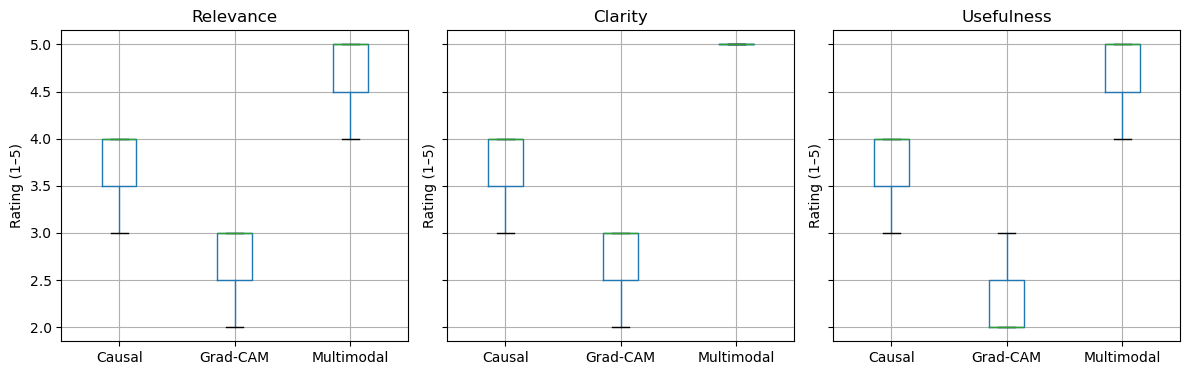

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

# Example data from previous answer
data = {
    "Method": ["Grad-CAM"]*3 + ["Causal"]*3 + ["Multimodal"]*3,
    "Relevance": [3,3,2, 4,4,3, 5,5,4],
    "Clarity":   [3,2,3, 4,3,4, 5,5,5],
    "Usefulness":[2,3,2, 4,4,3, 5,5,4]
}
df = pd.DataFrame(data)

fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

metrics = ["Relevance", "Clarity", "Usefulness"]

for ax, metric in zip(axes, metrics):
    df.boxplot(column=metric, by="Method", ax=ax)
    ax.set_title(metric)
    ax.set_xlabel("")
    ax.set_ylabel("Rating (1–5)")

plt.suptitle("")
plt.tight_layout()
plt.show()


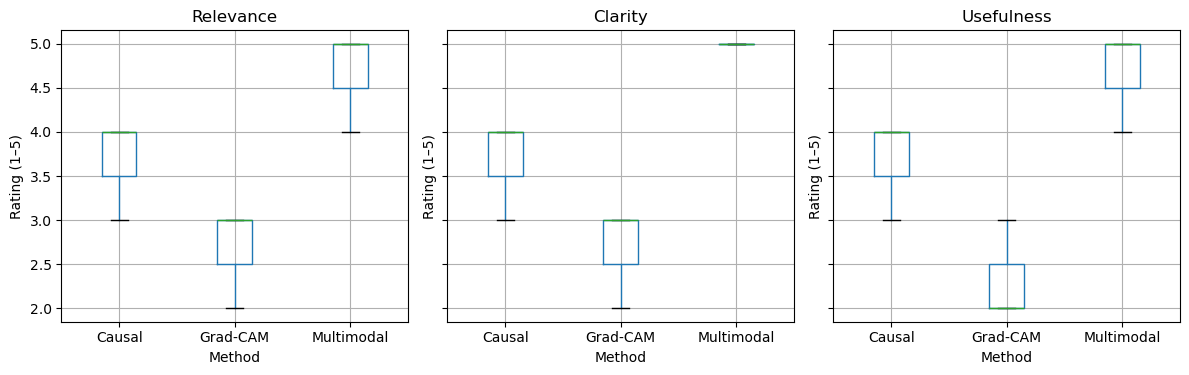

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

# Example ratings from 3 experts for the 3 XAI methods
data = {
    "Method": ["Grad-CAM"]*3 + ["Causal"]*3 + ["Multimodal"]*3,
    "Relevance":  [3, 3, 2,   4, 4, 3,   5, 5, 4],
    "Clarity":    [3, 2, 3,   4, 3, 4,   5, 5, 5],
    "Usefulness": [2, 3, 2,   4, 4, 3,   5, 5, 4]
}

df = pd.DataFrame(data)

# Create figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

metrics = ["Relevance", "Clarity", "Usefulness"]

for ax, metric in zip(axes, metrics):
    df.boxplot(column=metric, by="Method", ax=ax)
    ax.set_title(metric)
    ax.set_xlabel("Method")
    ax.set_ylabel("Rating (1–5)")

# Remove automatic pandas title
plt.suptitle("")
plt.tight_layout()
plt.show()


<Figure size 800x500 with 0 Axes>

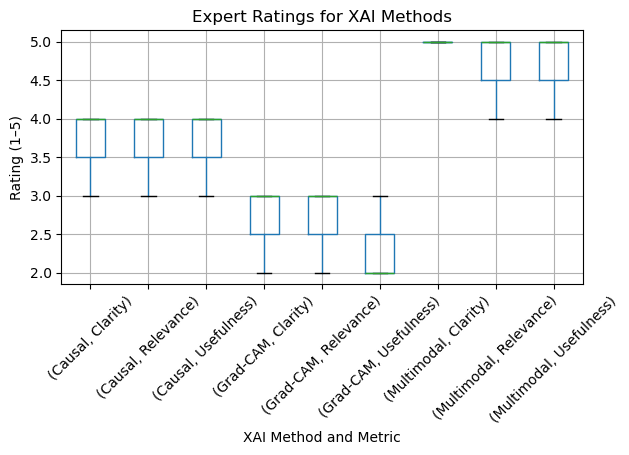

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

# Example ratings from 3 experts for the 3 XAI methods
data = {
    "Method": ["Grad-CAM"]*3 + ["Causal"]*3 + ["Multimodal"]*3,
    "Relevance":  [3, 3, 2,   4, 4, 3,   5, 5, 4],
    "Clarity":    [3, 2, 3,   4, 3, 4,   5, 5, 5],
    "Usefulness": [2, 3, 2,   4, 4, 3,   5, 5, 4]
}

df = pd.DataFrame(data)

# Melt to long format suitable for grouped plotting
df_melt = df.melt(id_vars="Method", var_name="Metric", value_name="Rating")

plt.figure(figsize=(8, 5))

# Grouped boxplot
df_melt.boxplot(by=["Method", "Metric"], column="Rating")

plt.title("Expert Ratings for XAI Methods")
plt.suptitle("")  # Remove automatic pandas title
plt.ylabel("Rating (1–5)")
plt.xlabel("XAI Method and Metric")

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


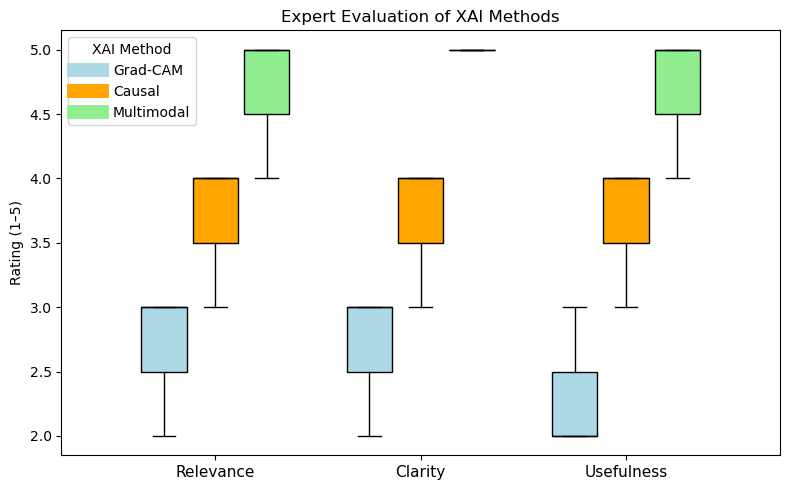

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Example ratings from 3 experts for the 3 XAI methods
data = {
    "Method": ["Grad-CAM"]*3 + ["Causal"]*3 + ["Multimodal"]*3,
    "Relevance":  [3, 3, 2,   4, 4, 3,   5, 5, 4],
    "Clarity":    [3, 2, 3,   4, 3, 4,   5, 5, 5],
    "Usefulness": [2, 3, 2,   4, 4, 3,   5, 5, 4]
}

df = pd.DataFrame(data)

methods = df["Method"].unique()
metrics = ["Relevance", "Clarity", "Usefulness"]

# Colors per method
colors = {
    "Grad-CAM": "lightblue",
    "Causal": "orange",
    "Multimodal": "lightgreen"
}

plt.figure(figsize=(8, 5))

box_positions = np.arange(len(metrics))
width = 0.25  # width shift per method

for i, method in enumerate(methods):
    subset = df[df["Method"] == method][metrics]

    plt.boxplot(
        subset.values,
        positions=box_positions + (i - 1) * width,
        widths=0.22,
        patch_artist=True,
        boxprops=dict(facecolor=colors[method], color='black'),
        medianprops=dict(color='black'),
        whiskerprops=dict(color='black'),
        capprops=dict(color='black')
    )

# X-axis labels
plt.xticks(box_positions, metrics, fontsize=11)

# Legend
for method in methods:
    plt.plot([], [], color=colors[method], label=method, linewidth=10)
plt.legend(title="XAI Method")

plt.ylabel("Rating (1–5)")
plt.title("Expert Evaluation of XAI Methods")
plt.tight_layout()
plt.savefig("xai_evaluation_boxplot.png", dpi=300, bbox_inches="tight")

plt.show()


In [13]:
from scipy.stats import friedmanchisquare
import pandas as pd

# ratings grouped by method (example)
gradcam_scores = [3,3,2, 3,2,3, 2,3,2]        # 3 metrics × 3 experts
causal_scores =   [4,4,3, 4,3,4, 4,4,3]
multi_scores =    [5,5,4, 5,5,5, 5,5,4]

stat, p = friedmanchisquare(gradcam_scores, causal_scores, multi_scores)
print("Friedman Test: chi2 =", stat, ", p =", p)


Friedman Test: chi2 = 18.0 , p = 0.00012340980408667962


In [15]:
from scipy.stats import wilcoxon

pairs = {
    "GradCAM vs Causal": wilcoxon(gradcam_scores, causal_scores),
    "GradCAM vs Multimodal": wilcoxon(gradcam_scores, multi_scores),
    "Causal vs Multimodal": wilcoxon(causal_scores, multi_scores)
}

for name, (stat, p) in pairs.items():
    print(name, "=> p =", p)


GradCAM vs Causal => p = 0.00390625
GradCAM vs Multimodal => p = 0.00390625
Causal vs Multimodal => p = 0.00390625
